### Machine Learning for Engineers: [Texture Classification](https://www.apmonitor.com/pds/index.php/Main/TextureClassification)
- [Texture Classification](https://www.apmonitor.com/pds/index.php/Main/TextureClassification)
 - Image features such as points, edges, or objects are used to identify an object in an image. One way to do material classification is by using local binary patterns to detect textures.
- [Course Overview](https://apmonitor.com/pds)
- [Course Schedule](https://apmonitor.com/pds/index.php/Main/CourseSchedule)

<img align=left width=400px src='https://apmonitor.com/pds/uploads/Main/texture_lbp_svm.png'>

### Import Packages

In [2]:
import os
import zipfile
import urllib.request
import numpy as np
from PIL import Image, ImageOps
from pathlib import Path
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns

# open source implementation of LBP
from skimage.feature import local_binary_pattern
# data preprocessing and metrics module in scikit-learn
from sklearn import preprocessing, metrics
# SVM implementation in scikit-learn
from sklearn.svm import LinearSVC

### Download Photos

In [4]:
# download s3_photos.zip
file = 's3_photos.zip'
url = 'http://apmonitor.com/pds/uploads/Main/'+file
urllib.request.urlretrieve(url, file)

# extract archive and remove bit_photos.zip
with zipfile.ZipFile(file, 'r') as zip_ref:
    zip_ref.extractall('./')
os.remove(file)

### Local Binary Patterns

In [5]:
def compute_lbp(arr):
    """Find LBP of all pixels.
    Also perform Vectorization/Normalization to get feature vector.
    """
    # LBP function params
    radius = 3
    n_points = 8 * radius
    n_bins = n_points + 2
    lbp = local_binary_pattern(arr, n_points, radius, 'uniform')
    lbp = lbp.ravel()
    # feature_len = int(lbp.max() + 1)
    feature = np.zeros(n_bins)
    for i in lbp:
        feature[int(i)] += 1
    feature /= np.linalg.norm(feature, ord=1)
    return feature

### Load Data

In [6]:
def load_data(tag='train'):
    """Load (training/test) data from the directory.
    Also do preprocessing of extra features. 
    """
    tag_dir = Path.cwd() / tag
    vec = []
    cat = []
    for cat_dir in tag_dir.iterdir():
        cat_label = cat_dir.stem
        for img_path in cat_dir.glob('*.png'):
            img = Image.open(img_path.as_posix())
            if img.mode != 'L':
                img = ImageOps.grayscale(img)
                img.save(img_path.as_posix())
            arr = np.array(img)
            feature = compute_lbp(arr)
            vec.append(feature)
            cat.append(cat_label)
    return vec, cat

# train photos
vec_train, cat_train = load_data('train')
# test photos
vec_test, cat_test   = load_data('test')

### List the categories

In [7]:
# get unique categories
labels = list(np.unique(np.array(cat_train)))
labels

['Sand', 'Seed', 'Stone']

### Label Encoder

In [9]:
le = preprocessing.LabelEncoder()
label_train = le.fit_transform(cat_train)
label_test = le.transform(cat_test)

In [11]:
label_test

array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2])

### Support Vector Machine fit

In [12]:
clf = LinearSVC(random_state=0, tol=1e-5)
clf.fit(vec_train, label_train)

LinearSVC(random_state=0, tol=1e-05)

### Evaluation

Accuracy: 93.33%


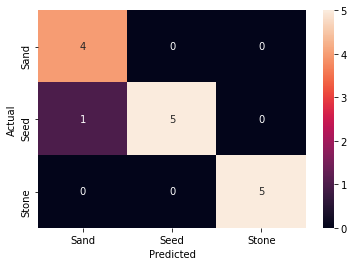

In [13]:
# test set evaluation
prediction = clf.predict(vec_test)
# visualization
cmat = metrics.confusion_matrix(prediction,label_test)
s = sns.heatmap(cmat,annot=True,xticklabels=labels, yticklabels=labels)
s.set(xlabel='Predicted', ylabel='Actual')
acc = cmat.trace() / cmat.sum()
print('Accuracy: {0:5.2f}%'.format(acc*100))